# Chapter 10: Credit Risk
&copy; 2019 Kenneth Winston

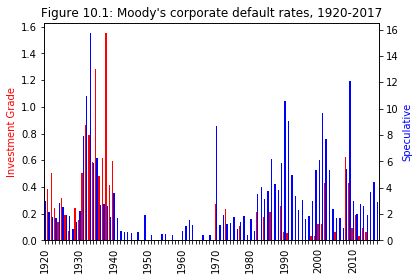

In [2]:
#Display bar charts with investment grade and speculative
#grade defaults year by year
#Data from Moody's Corporate Default and Recovery Rates,
#1920-2017, Exhibit 30
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

yearrange=np.arange(1920,2018)

moodys={'invt' : pd.Series([ \
0.427,0.387,0.506,0.244,0.14,0.321,0.188, \
0.069,0,0.242,0.151,0.502,0.861,0.79,0.586, \
1.285,0.482,0.619,1.55,0.412,0.592,0,0, \
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0, \
0,0,0,0,0,0,0,0.271,0,0,0.232,0,0,0, \
0.11,0,0,0,0,0.214,0,0.175,0,0.211, \
0,0,0.254,0.06,0.059,0,0,0,0,0,0,0.03,0.032, \
0.126,0.124,0.431,0,0,0.061,0,0,0.627,0.428, \
0.095,0.187,0.033,0.096,0.063,0,0,0], index=yearrange), \
'spec' : pd.Series([ \
3.009,2.15,1.762,1.704,2.852,2.562,1.909, \
1.831,0.877,1.401,2.204,7.897,10.989,15.709, \
5.897,6.253,2.72,2.749,2.599,1.774,3.562, \
1.713,0.736,0.615,0.666,0.564,0,0.636,0,1.926, \
0,0.433,0,0,0.467,0.518,0,0.448,0,0,0.75,\
1.072,1.516,1.152,0,0,0.439,0,0.375,0,8.678, \
1.155,1.922,1.28,1.332,1.742,0.868,1.36,1.823, \
0.435,1.63,0.698,3.553,4.061,3.13,3.773,6.163, \
4.31,3.85,5.91,10.54,9.096,4.933,3.404, \
2.341,3.063,1.651,1.889,3.028,5.361,6.074, \
9.634,7.663,5.33,2.418,1.721,1.669,0.945, \
5.426,12.11,3.013,1.982,2.756,2.625,1.938, \
3.67,4.45,2.91], index=yearrange)}

mdf=pd.DataFrame(moodys)

fig=plt.figure() # Create matplotlib figure

#Set up two axes because of different orders of
#magnitude between IG and HY
ax = fig.add_subplot(111)
ax2 = ax.twinx() # Create another axis that shares the same x-axis as ax.

width = 0.4

mdf.invt.plot(kind='bar', color='red', ax=ax, width=width, position=1)
mdf.spec.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Investment Grade', color='red')
ax2.set_ylabel('Speculative', color='blue')

#Only show year labels every tick_spacing years
tick_spacing = 10
for i,label in enumerate(ax.get_xticklabels()):
    if np.mod(i,tick_spacing)!=0:
        label.set_visible(False)

plt.title("Figure 10.1: Moody's corporate default rates, 1920-"+str(max(yearrange)))
plt.show()

In [3]:
#Show averages, mins, maxes
print('Investment grade:')
print('    Min: ',min(mdf.invt))
print('    Avg: ',np.average(mdf.invt))
print('    Max: ',max(mdf.invt)," Year: ",mdf.loc[mdf.invt==max(mdf.invt)].index[0])
print('    Percentage of years with no defaults: ',mdf.invt.value_counts().iloc[0]*100./len(mdf.invt))
print('Speculative:')
print('    Min: ',min(mdf.spec))
print('    Avg: ',np.average(mdf.spec))
print('    Max: ',max(mdf.spec)," Year: ",mdf.loc[mdf.spec==max(mdf.spec)].index[0])
print('    Percentage of years with no defaults: ',mdf.spec.value_counts().iloc[0]*100./len(mdf.spec))

Investment grade:
    Min:  0.0
    Avg:  0.14564285714285713
    Max:  1.55  Year:  1938
    Percentage of years with no defaults:  57.142857142857146
Speculative:
    Min:  0.0
    Avg:  2.8137653061224492
    Max:  15.709  Year:  1933
    Percentage of years with no defaults:  12.244897959183673


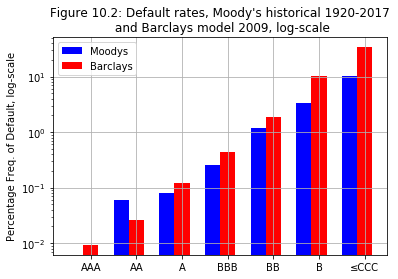

In [4]:
#Data from Moody's Corporate Default and Recovery Rates,
#1920-2017 Exhibit 32 (1-year) and Barclays Capital,
#“The Corporate Default Probability Model,” April 2009
ratings=['AAA','AA','A','BBB','BB','B','≤CCC']
moodys=[0,.06,.08,.26,1.21,3.42,10.11]
edf2009=[.0093,.0264,.1198,.4393,1.852,10.22,33.904]
indices = [1,2,3,4,5,6,7]
#Calculate optimal width
width = np.min(np.diff(indices))/3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width,moodys,width,color='b',label='Moodys')
ax.bar(indices,edf2009,width,color='r',label='Barclays')
plt.grid()
plt.xticks(indices,ratings)
plt.yscale('log')
plt.ylabel('Percentage Freq. of Default, log-scale')
plt.legend()
plt.title("Figure 10.2: Default rates, Moody's historical 1920-2017\n and Barclays model 2009, log-scale")
plt.show()

VIX data starts 1986-01
AAA/VIX level correlation: 0.49700
BBB/VIX level correlation: 0.66604
AAA/VIX difference correlation: 0.47843
BBB/VIX difference correlation: 0.52497
Spread and Treasury data starts 1919-01
AAA/BBB level correlation: 0.73926
AAA/Tsy difference correlation: -0.36398
BBB/Tsy difference correlation: -0.22994
AAA/BBB difference correlation: 0.66917


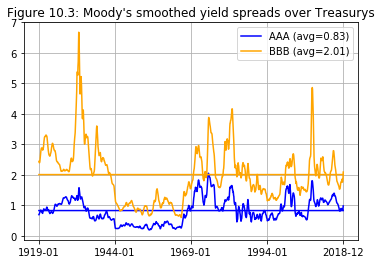

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import pandas as pd
import qrbook_funcs as qf
#Get Moody's AAA and BBB yields from FRED.
#Splice together long-term US Treasury rate series,
#and subtract them off to form credit spreads.
#Display and correlate with VIX

lastday=qf.LastYearEnd()
seriesnames=['AAA','BAA','M1333AUSM156NNBR', \
             'LTGOVTBD','IRLTCT01USM156N']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,
            enddate=lastday)

#Splice together the three overlapping long-term
#Treasury series. They agree where they overlap
longterm=[]
for t in range(len(ratematrix)):
    #Take average of non-nan values of the overlapping series
    longterm.append(np.nansum(ratematrix[t][2:5])/np.count_nonzero(~np.isnan(ratematrix[t][2:5])))

n=len(longterm)

#Get VIX index which is daily
vxnames=['VXOCLS','VIXCLS']
vxdates,vxmatrix=qf.GetFREDMatrix(vxnames,
            enddate=lastday)

#Align VIX's; monthly dates for bond yields look like
#YYYY-MM-01 but they're really the last business day
vixstart=cdates.index(vxdates[0][:8]+'01')
iv=0
for ic in range(vixstart,len(cdates)):
    #New month coming up in VIX series?
    while True:
        usethisguy=(iv==len(vxdates)-1)
        if not usethisguy:
            usethisguy=(vxdates[iv][5:7]!=vxdates[iv+1][5:7])
        if usethisguy:
            #Look for non-NaN
            looking=True
            while looking:
                vix=vxmatrix[iv][1]
                looking=np.isnan(vix)
                if looking:
                    vix=vxmatrix[iv][0]
                    #Are both nan?
                    looking=np.isnan(vix)
                    if looking:
                        iv+=1  #Try next date
            #Found a non-NaN VIX
            #Append VIX value to data
            ratematrix[ic].append(vix)
            iv+=1
            break
        iv+=1

#time series of differences is rough - smooth it
#Roughness probably comes from different timings of
#observations of corporate yields and Treasurys
back=5  #Will take rolling back-month averages
aaa=[x[0]-y for (x,y) in zip(ratematrix,longterm)]
aaamean=np.mean(aaa)
aaa2=np.cumsum(aaa)
aaa3=(aaa2[back:]-aaa2[:-back])/back
aaa=np.concatenate((aaa3, aaa[-back:]), axis=0)  #Fix up the end

bbb=[x[1]-y for (x,y) in zip(ratematrix,longterm)]
bbbmean=np.mean(bbb)
bbb2=np.cumsum(bbb)
bbb3=(bbb2[back:]-bbb2[:-back])/back
bbb=np.concatenate((bbb3, bbb[-back:]), axis=0)

#Apply same transform to Treasurys for correlation
tsy2=np.cumsum(longterm)
tsy3=(tsy2[back:]-tsy2[:-back])/back
tsy=np.concatenate((tsy3, longterm[-back:]), axis=0)

#Smooth VIX too
vix=[x[5] for x in ratematrix[vixstart:]]
vix2=np.cumsum(vix)
vix3=(vix2[back:]-vix2[:-back])/back
vix=np.concatenate((vix3, vix[-back:]), axis=0)

#Correlate smoothed spreads with VIX
av_level=scipy.stats.pearsonr(vix,aaa[vixstart:])[0]
bv_level=scipy.stats.pearsonr(vix,bbb[vixstart:])[0]
av_diff=scipy.stats.pearsonr(np.diff(vix),np.diff(aaa[vixstart:]))[0]
bv_diff=scipy.stats.pearsonr(np.diff(vix),np.diff(bbb[vixstart:]))[0]
print("VIX data starts",cdates[vixstart][:7])
print("AAA/VIX level correlation: %.5f" % av_level)
print("BBB/VIX level correlation: %.5f" % bv_level)
print("AAA/VIX difference correlation: %.5f" % av_diff)
print("BBB/VIX difference correlation: %.5f" % bv_diff)

ab_level=scipy.stats.pearsonr(aaa,bbb)[0]
at_diff=scipy.stats.pearsonr(np.diff(aaa),np.diff(tsy))[0]
bt_diff=scipy.stats.pearsonr(np.diff(bbb),np.diff(tsy))[0]
ab_diff=scipy.stats.pearsonr(np.diff(aaa),np.diff(bbb))[0]
print("Spread and Treasury data starts",cdates[0][:7])
print("AAA/BBB level correlation: %.5f" % ab_level)
print("AAA/Tsy difference correlation: %.5f" % at_diff)
print("BBB/Tsy difference correlation: %.5f" % bt_diff)
print("AAA/BBB difference correlation: %.5f" % ab_diff)

#Show spread time series and straight line for averages
alabel='AAA (avg=%1.2f' % aaamean
alabel+=')'
plt.plot(range(n),aaa,label=alabel,color='blue')
plt.plot(range(n),[aaamean]*n,color='blue')
blabel='BBB (avg=%1.2f' % bbbmean
blabel+=')'
plt.plot(range(n),bbb,label=blabel,color='orange')
plt.plot(range(n),[bbbmean]*n,color='orange')

plt.legend()
plt.grid()
stride=int((n+1)/4)
places=np.arange(0,n+stride,stride)
places[len(places)-1]=n-1
displaydates=[cdates[j][:7] for j in places]    
plt.xticks(places,displaydates)
plt.title("Figure 10.3: Moody's smoothed yield spreads over Treasurys")
plt.show();

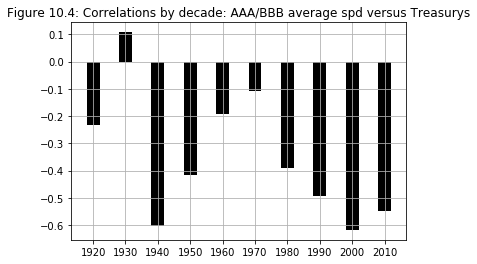

In [29]:
lastdecade=int(lastday[:3])
lastdecade*=10
decades=np.arange(1920,lastdecade+1,10)

decade_starts=[]
for d in decades:
    decade_string=str(d)+'-01-01'
    decade_starts.append(cdates.index(decade_string))
    
#Close out most recent decade
decade_starts.append(len(cdates))

decade_correlations=[]
for i,d in enumerate(decades):
    avgspd_decade=( \
        aaa[decade_starts[i]:decade_starts[i+1]]+ \
        bbb[decade_starts[i]:decade_starts[i+1]])/2
    tsy_decade=tsy[decade_starts[i]:decade_starts[i+1]]
    avgt_diff=scipy.stats.pearsonr(np.diff(avgspd_decade),np.diff(tsy_decade))[0]
    decade_correlations.append(avgt_diff)

#Display bar chart
indices=np.arange(len(decades))
width = 0.4
plt.bar(indices,decade_correlations,width,color='black')
plt.grid()
plt.xticks(indices,decades)
plt.title("Figure 10.4: Correlations by decade: AAA/BBB average spd versus Treasurys")
plt.show()